In [1]:
# imports
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
from math import log10
import pandas as pd
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time


from google.colab import drive
drive.mount('/content/Gdrive', force_remount=True)
dir = "/content/Gdrive/My Drive/Colab Notebooks/PRE/Multi-Modalities/"
data_dir = "/content/Gdrive/My Drive/Colab Notebooks/PRE/Data/"
#dir = "/Users/Alex2/Desktop/Multi Modalities/"
#data_dir = dir
sys.path.append(dir)

# Own packages
from data import get_training_set, get_test_set
from edsr import EDSR
from ssim import ssim

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/Gdrive


In [2]:
# Training settings:
batchSize = 32
testBatchSize = 32
nEpochs = 100
lr = 0.0001
threads = 8
seed = 123
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cold_start = False
early_upsampling = False

# Model :
upscale_factor = 3
input_channels = ["flair"]
target_channels = ['flair']
patch_size = [240, 240]
n_resblocks = 32
n_patch_feats = 128

In [3]:
# Paths :
training_path = data_dir + "Data/train/"
test_path = data_dir + "Data/test/"
#training_path = data_dir + "Data/smallTrain/"
#test_path = data_dir + "Data/smallTest/"

modelName = "flair->flair 32blocs"

In [4]:
training_folder = dir + "Trainings/" + modelName
model_weights = training_folder + "/Pre_trained_model/"
stats_path = training_folder + "/Stats/"
images_path = training_folder + "/Training_images/"
summary_path = training_folder + "/Summary/"

paths = [training_folder, model_weights, stats_path, images_path, summary_path]
for path in paths:
    try:
        os.stat(path)
    except:
        os.makedirs(path) 

In [5]:
print('===> Loading datasets')
train_set = get_training_set(upscale_factor, input_channels, target_channels, training_path, patch_size=patch_size, early_upsampling=early_upsampling)
test_set = get_test_set(upscale_factor, input_channels, target_channels, test_path, patch_size=patch_size, early_upsampling=early_upsampling)

training_data_loader = DataLoader(dataset=train_set, num_workers=threads, batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=threads, batch_size=testBatchSize, shuffle=False)

print("{} training images / {} testing images".format(len(train_set), len(test_set)))
print("===> dataset loaded !")

===> Loading datasets
3880 training images / 960 testing images
===> dataset loaded !


In [6]:
print('===> Building model')
#model = Net(upscale_factor=upscale_factor, input_channels=input_channels).to(device)
model = EDSR(upscale_factor, input_channels, target_channels, n_resblocks=n_resblocks, n_feats=n_patch_feats, res_scale=.1, bn=None).to(device)
print(model.parameters())

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
    
print(model)
print("==> Model built")

===> Building model
<generator object Module.parameters at 0x7fc35a5ce678>
EDSR(
  (act): ReLU(inplace=True)
  (head): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): 

In [7]:
def calc_psnr(x):
    return 10 * log10(1/x)

def calc_ssim(pred, target):
    ssim_score  = ssim(pred, target, window_size=11, size_average=True).item()
    return ssim_score

def show(epoch, pred, target, title=""):
    psnr = 10 * log10(1/criterion(pred, target))

    pred = pred.detach().numpy()
    norm = 255./(pred.max()-pred.min())
    pred *= norm
    pred.clip(0, 255)

    target = target.detach().numpy()
    norm = 255./(target.max()-target.min())
    target *= norm
    target.clip(0, 255)


    residual = np.abs(pred - target)
    residual -= residual.min()
    norm = 255./(residual.max()-residual.min())
    residual *= norm
    residual.clip(0, 255)
    
    pred = Image.fromarray(pred, mode='F').convert('L')
    pred.save(images_path + "{}_epoch_{:.4f}_{}dB_{}".format(modelName, epoch, psnr, title+"_prediction.jpg"))
    target = Image.fromarray(np.uint8(target), mode='L')
    target.save(images_path + "{}_epoch_{}_{}".format(modelName, epoch, title+"_target.jpg"))
    residual = Image.fromarray(np.uint8(residual), mode='L')
    residual.save(images_path + "{}_epoch_{}_{}".format(modelName, epoch, title+"_residual.jpg"))

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches((15,10))
    axs[0].imshow(target, cmap='gray')
    axs[0].set_title("Target " + title)
    axs[2].imshow(residual)
    axs[2].set_title("Residual ")
    axs[1].imshow(pred, cmap='gray')
    axs[1].set_title("Prediction " + title + ' psnr= {:.4f} dB'.format(psnr))
    fig.savefig(summary_path + "{}_epoch_{}_{}".format(modelName, epoch, title+"_summary.jpg"))
    plt.close()

In [8]:
def train(epoch):
    epoch_loss = 0
    epoch_loss_indiv = [0 for x in range(len(target_channels))]
    epoch_ssim_indiv = [0 for x in range(len(target_channels))]
    for iteration, batch in enumerate(training_data_loader, 1):
        inp, target, mask = batch[0].to(device), batch[1].to(device), batch[2].to(device).to(device=device, dtype=torch.float32)

        optimizer.zero_grad()
        prediction = model(inp)

        loss = 0
        for x in range(len(target_channels)):
            loss_x = criterion(prediction[:, x, :, :], target[:, x, :, :])
            ssim_x = calc_ssim(prediction[:, x, :, :].view(len(batch[0]), 1, 240, 240), target[:, x, :, :].view(len(batch[0]), 1, 240, 240))
            epoch_loss_indiv[x] += loss_x.item()
            epoch_ssim_indiv[x] += ssim_x
            loss += loss_x

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    epochLoss = epoch_loss / len(training_data_loader)

    for x in range(len(target_channels)):
            epoch_loss_indiv[x] /= len(training_data_loader)
            epoch_ssim_indiv[x] /= len(training_data_loader)

    psnr_indiv = list(map(calc_psnr, epoch_loss_indiv))
    psnr = calc_psnr(epochLoss)
    print("psnr_indiv= ", psnr_indiv, "global_psnr= ", psnr)

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epochLoss))
    pred = prediction.cpu()[0]
    target = target.cpu()[0]

    for p, t, c_name in zip(pred, target, target_channels):
        show(epoch, p, t, "train_"+c_name)
    return psnr, psnr_indiv, epoch_ssim_indiv


def test(epoch):
    avg_psnr = 0
    epoch_loss_indiv = [0 for x in range(len(target_channels))]
    epoch_ssim_indiv = [0 for x in range(len(target_channels))]
    with torch.no_grad():
        for c, batch in enumerate(testing_data_loader):
            inp, target, mask = batch[0].to(device), batch[1].to(device), batch[2].to(device).to(device=device, dtype=torch.float32)

            prediction = model(inp)
            mse = criterion(prediction, target)

            for x in range(len(target_channels)):
                loss_x = criterion(prediction[:, x, :, :], target[:, x, :, :])
                ssim_x = calc_ssim(prediction[:, x, :, :].view(len(batch[0]), 1, 240, 240), target[:, x, :, :].view(len(batch[0]), 1, 240, 240))
                epoch_loss_indiv[x] += loss_x.item()
                epoch_ssim_indiv[x] += ssim_x

            psnr = 10 * log10(1/mse.item())
            avg_psnr += psnr
            
        print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
        pred = prediction.cpu()[0]
        target = target.cpu()[0]

        for p, t, c_name in zip(pred, target, target_channels):
            show(epoch, p, t, " "+c_name)

        for x in range(len(target_channels)):
            epoch_loss_indiv[x] /= len(testing_data_loader)
            epoch_ssim_indiv[x] /= len(testing_data_loader)
            

        psnr_indiv = list(map(calc_psnr, epoch_loss_indiv))
    return avg_psnr / len(testing_data_loader), psnr_indiv, epoch_ssim_indiv


def save_checkpoint(ckp, stats, save_path):
    model_out_path = save_path + modelName
    torch.save(ckp, model_out_path + ".pth") #save ckp
    torch.save(ckp['state_dict'], model_out_path + "model_epoch_{}.pth".format(epoch)) #save model
    print("Checkpoint saved to {}".format(model_out_path))

def load_checkpoint(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch'], checkpoint['stats'], checkpoint['stats']['elapsed_time'][-1]

In [9]:
print("==> Starts to train")
try:
    if cold_start:
        raise Exception
    model, optimizer, start_epoch, stats, start_time = load_checkpoint(model_weights+modelName+".pth", model, optimizer)
    print("Training resumed at epoch ", start_epoch)
except:
    print("training from scratch")
    start_epoch=0

    stats = {
    'model': modelName,
    'lr': lr,
    'epoch': [],
    'elapsed_time': [],
    'train_PSNR': [],
    'test_PSNR': [],
    'train_PSNR_t1w': [],
    'test_PSNR_t1w': [],
    'train_ssim_t1w': [],
    'test_ssim_t1w': [],
    'train_PSNR_t1gd': [],
    'test_PSNR_t1gd': [],
    'train_ssim_t1gd': [],
    'test_ssim_t1gd': [],
    'train_PSNR_t2w': [],
    'test_PSNR_t2w': [],
    'train_ssim_t2w': [],
    'test_ssim_t2w': [],
    'train_PSNR_flair': [],
    'test_PSNR_flair': [],
    'train_ssim_flair': [],
    'test_ssim_flair': []
    }
    start_time = time.time()



for epoch in range(start_epoch, nEpochs + 1):

    test_psnr, test_psnr_indiv, test_ssim = test(epoch)
    train_psnr, train_psnr_indiv, train_ssim = train(epoch)

    test_per_modality = {target_channels[x]: test_psnr_indiv[x] for x in range(len(target_channels))}
    train_per_modality = {target_channels[x]: train_psnr_indiv[x] for x in range(len(target_channels))}
    test_ssim_per_modality = {target_channels[x]: test_ssim[x] for x in range(len(target_channels))}
    train_ssim_per_modality = {target_channels[x]: train_ssim[x] for x in range(len(target_channels))}
    print("test_per_mod", test_per_modality)
    print("train_per_mod", train_per_modality)

    stop_time = time.time()
    elapsed_time = np.round(stop_time - start_time, 2)
    stats['elapsed_time'].append(elapsed_time)
    stats['epoch'].append(epoch)
    stats['train_PSNR'].append(train_psnr)
    stats['test_PSNR'].append(test_psnr)
    stats['train_PSNR_t1w'].append(0)
    stats['test_PSNR_t1w'].append(0)
    stats['train_ssim_t1w'].append(0)
    stats['test_ssim_t1w'].append(0)
    stats['train_PSNR_t1gd'].append(0)
    stats['test_PSNR_t1gd'].append(0)
    stats['train_ssim_t1gd'].append(0)
    stats['test_ssim_t1gd'].append(0)
    stats['train_PSNR_t2w'].append(0)
    stats['test_PSNR_t2w'].append(0)
    stats['train_ssim_t2w'].append(0)
    stats['test_ssim_t2w'].append(0)
    stats['train_PSNR_flair'].append(0)
    stats['test_PSNR_flair'].append(0)
    stats['train_ssim_flair'].append(0)
    stats['test_ssim_flair'].append(0)
    for x in target_channels:
        stats['test_PSNR_' + x][-1] = test_per_modality[x]
        stats['train_PSNR_' + x][-1] = train_per_modality[x]
        stats['test_ssim_' + x][-1] = test_ssim_per_modality[x]
        stats['train_ssim_' + x][-1] = train_ssim_per_modality[x]


    ckp = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(), 
        'stats': stats
    }
    save_checkpoint(ckp, stats, model_weights)

    df = pd.DataFrame(
        data=stats, 
        columns=['model', 'lr', 'epoch', 'elapsed_time', 'train_PSNR','test_PSNR', 'train_PSNR_t1w', 'test_PSNR_t1w', 'train_ssim_t1w', 'test_ssim_t1w','train_PSNR_t1gd', 'test_PSNR_t1gd', 'train_ssim_t1gd', 'test_ssim_t1gd','train_PSNR_t2w', 'test_PSNR_t2w', 'train_ssim_t2w', 'test_ssim_t2w','train_PSNR_flair', 'test_PSNR_flair''train_ssim_flair', 'test_ssim_flair']
        )
    df.to_csv(stats_path + modelName + "_stats.csv")

print("===> Display results")
df = pd.DataFrame(
        data=stats, 
        columns=['model', 'lr', 'epoch', 'elapsed_time', 'train_PSNR','test_PSNR', 'train_PSNR_t1w', 'test_PSNR_t1w', 'train_ssim_t1w', 'test_ssim_t1w','train_PSNR_t1gd', 'test_PSNR_t1gd', 'train_ssim_t1gd', 'test_ssim_t1gd','train_PSNR_t2w', 'test_PSNR_t2w', 'train_ssim_t2w', 'test_ssim_t2w','train_PSNR_flair', 'test_PSNR_flair''train_ssim_flair', 'test_ssim_flair']
        )
df.to_csv(dir + modelName + "_stats.csv")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
===> Epoch[61](122/122): Loss: 0.0002
psnr_indiv=  [36.841480190801676] global_psnr=  36.841480190801676
===> Epoch 61 Complete: Avg. Loss: 0.0002
test_per_mod {'flair': 40.73788067323568}
train_per_mod {'flair': 36.841480190801676}
Checkpoint saved to /content/Gdrive/My Drive/Colab Notebooks/PRE/Multi-Modalities/Trainings/flair->flair 32blocs/Pre_trained_model/flair->flair 32blocs
===> Avg. PSNR: 41.1559 dB
===> Epoch[62](1/122): Loss: 0.0002
===> Epoch[62](2/122): Loss: 0.0002
===> Epoch[62](3/122): Loss: 0.0002
===> Epoch[62](4/122): Loss: 0.0002
===> Epoch[62](5/122): Loss: 0.0003
===> Epoch[62](6/122): Loss: 0.0002
===> Epoch[62](7/122): Loss: 0.0003
===> Epoch[62](8/122): Loss: 0.0002
===> Epoch[62](9/122): Loss: 0.0002
===> Epoch[62](10/122): Loss: 0.0003
===> Epoch[62](11/122): Loss: 0.0002
===> Epoch[62](12/122): Loss: 0.0002
===> Epoch[62](13/122): Loss: 0.0002
===> Epoch[62](14/122): Loss: 0.0002
=

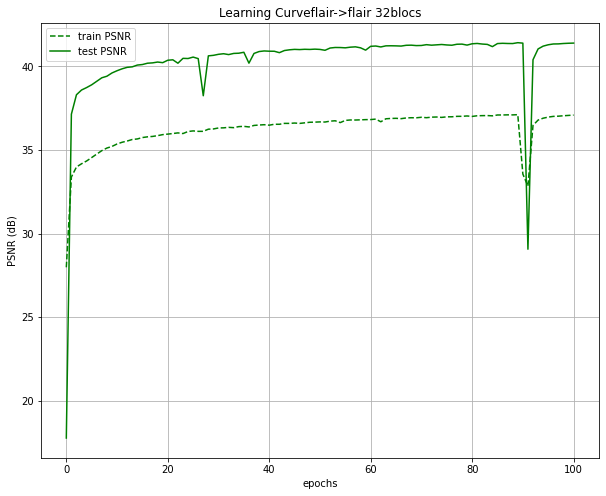

<Figure size 432x288 with 0 Axes>

In [10]:
def plot(x, label, linestyle='solid', color='g'):
    t = np.arange(0, len(x), 1)
    plt.plot(t, x, label=label, linestyle=linestyle, color=color)

plt.figure(figsize=(10, 8))
plot(stats['train_PSNR'], "train PSNR", linestyle="dashed", color="g")
plot(stats['test_PSNR'], "test PSNR", linestyle="solid", color="g")
plt.legend()
plt.grid()
plt.xlabel("epochs")
plt.ylabel("PSNR (dB)")
plt.title("Learning Curve" + modelName)
plt.show()
plt.savefig(dir+'/'+modelName + "lc.jpg")